In [1]:
%matplotlib inline
%matplotlib notebook
import os
import cv2
from PIL import Image
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pytorch_lightning as pl

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


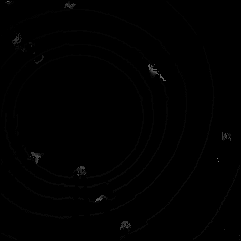

In [2]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev/4.png") as img:
    display(img)

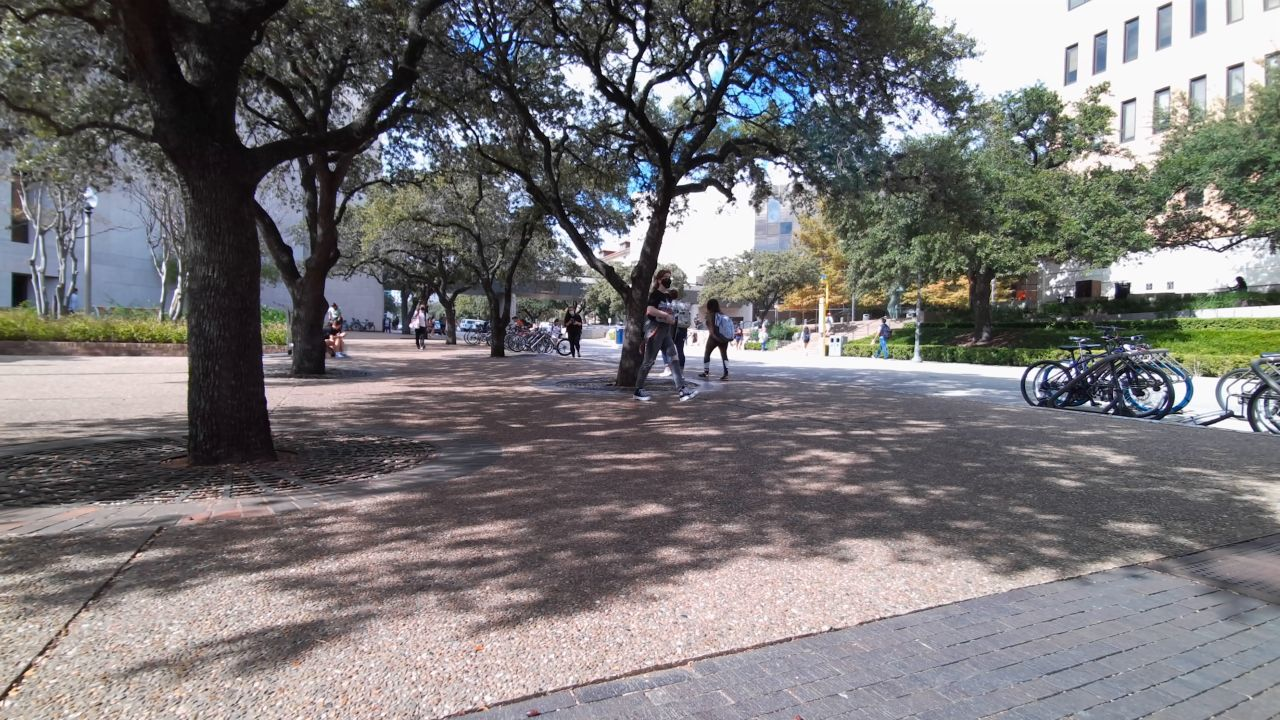

<IPython.core.display.Javascript object>


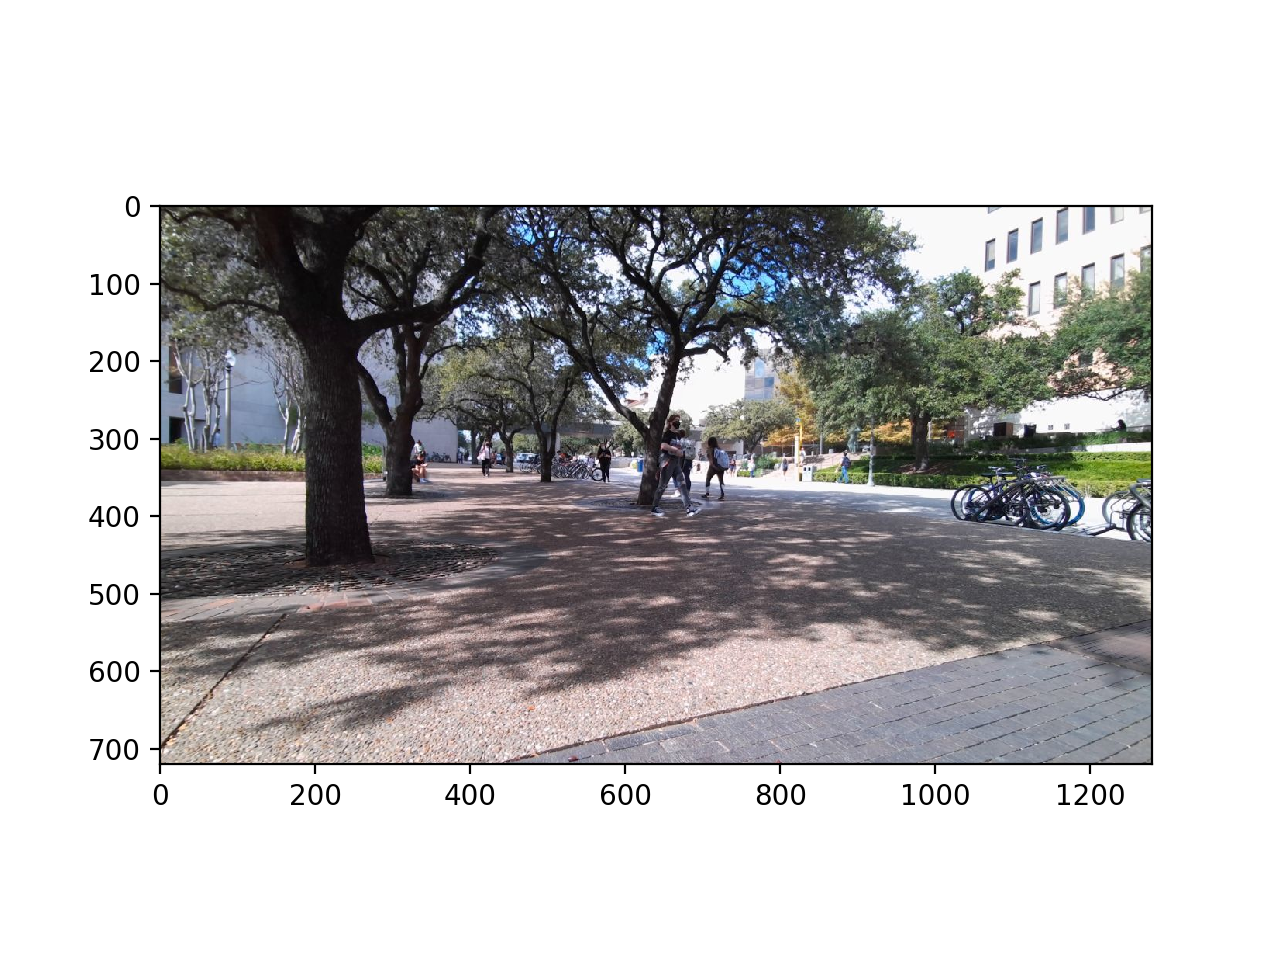

In [3]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_rgb_img/0.png") as img:
    display(img)
    plt.imshow(img)

In [4]:
bev_frms = [file for file in os.listdir("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev")]
len(bev_frms)

2062

<IPython.core.display.Javascript object>


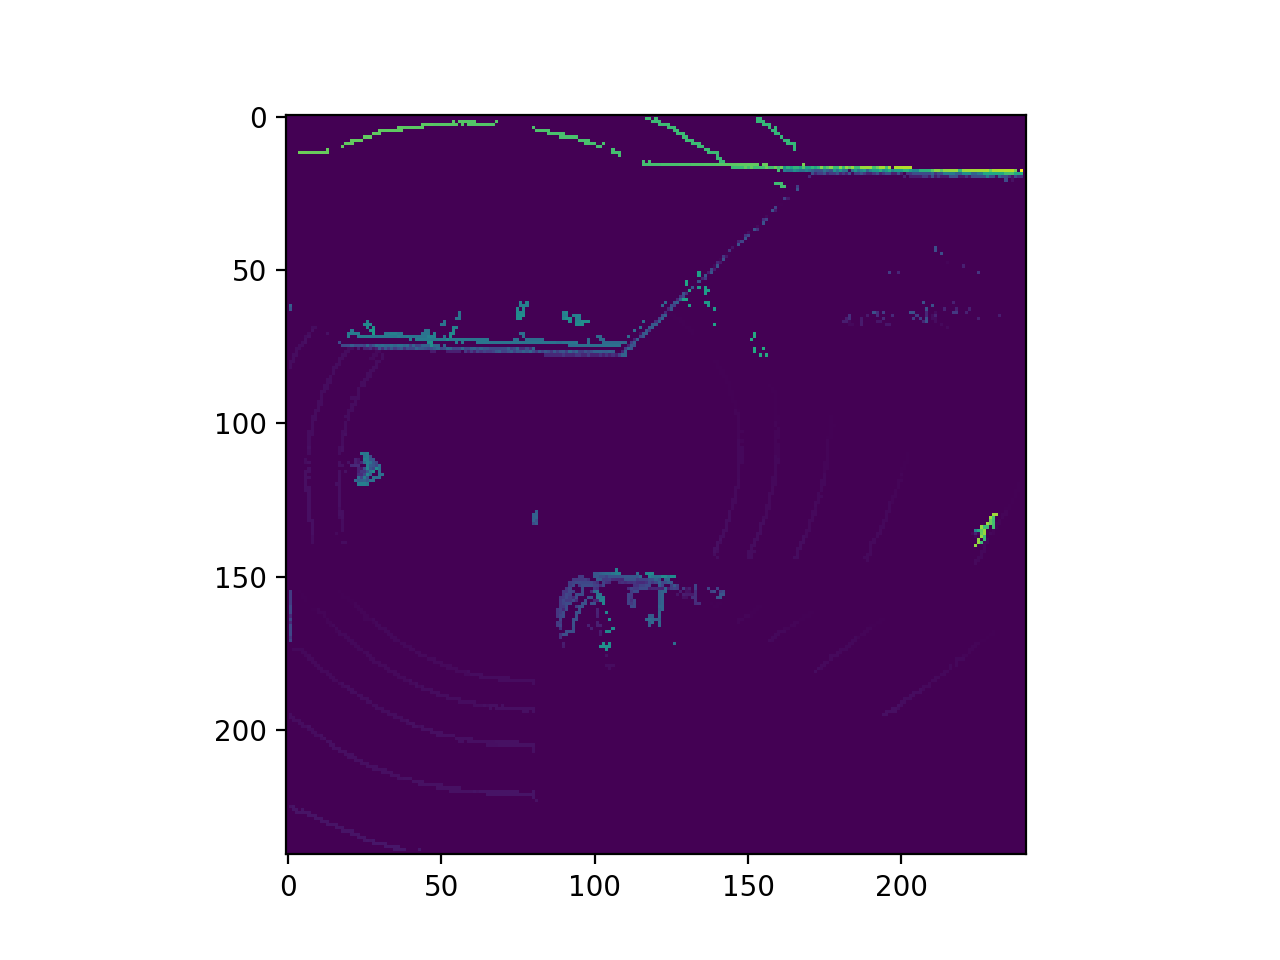

In [49]:
fig, ax = plt.subplots()
ims = []

for i in range(len(bev_frms)):
    with Image.open(f"./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev/{i}.png") as img:
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

In [2]:
from models.dataloader import NavSet, NavSetDataModule
from models.encoder import VisionTransformer
from models.decoder import TransformerDecoder
from models.model import AttnNav
from torch.utils.data import DataLoader, ConcatDataset

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
trainset = NavSet("./data", "./data/A_Spot_Library_AHG_Tue_Nov_9_43.bag")
print(trainset.__len__())
valset = NavSet("./data", "./data/A_Spot_Library_Dobie_Wed_Nov_10_57.bag")
print(valset.__len__())

3291
2062


In [11]:
trainset2 = NavSet("./data", "./data/A_Spot_Library_AHG_Tue_Nov_9_43.bag")
print(trainset2.__len__())
valset2 = NavSet("./data", "./data/A_Spot_Library_AHG_Tue_Nov_9_43.bag", is_train=False)
print(valset2.__len__())

trainset = ConcatDataset([trainset1, trainset2])
valset = ConcatDataset([valset1, valset2])

None
None


NameError: name 'trainset1' is not defined

In [4]:
trainloader = DataLoader(trainset, batch_size=16, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=16, num_workers=8, pin_memory=True)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder1 = VisionTransformer(input_channels=1)
encoder2 = VisionTransformer()
decoder = TransformerDecoder()

model = AttnNav(encoder2, encoder1, decoder)
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])

batch_size = 16
criterion = nn.MSELoss(reduction = 'sum').to(device)
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
trainSteps = len(trainset) // batch_size
testSteps = len(valset) // batch_size

cuda


In [6]:
H = {"train_loss": [], "val_loss": []}

for e in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    #adjust_learning_rate(optimizer, e, num_epochs, learning_rate)
    
    for i, (image, lidar, pose) in enumerate(trainloader):
        (image, lidar, pose) = (image.to(device), lidar.to(device), pose.to(device))
        output = model(image, lidar, pose)
        
        loss = criterion(output, pose)
        #print(torch.cuda.memory_summary(device=None, abbreviated=False))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().item()
    
    with torch.no_grad():
        model.eval()
        
        for (image, lidar, pose) in valloader:
            (image, lidar, pose) = (image.to(device), lidar.to(device), pose.to(device))
            pred = model(image, lidar, pose)
            p_loss = criterion(pred, pose)
            val_loss += p_loss.item()
    
        avgTrainloss = train_loss/trainSteps
        avgValloss = val_loss/testSteps
    
    H["train_loss"].append(avgTrainloss)
    H["val_loss"].append(avgValloss)
    
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Validation loss: {:.4f}'.format(e, num_epochs, avgTrainloss, avgValloss))

Epoch 0/20 : Training loss: 26.2999 | Validation loss: 16.5933
Epoch 1/20 : Training loss: 10.4270 | Validation loss: 15.9109
Epoch 2/20 : Training loss: 9.6041 | Validation loss: 15.6929
Epoch 3/20 : Training loss: 9.2459 | Validation loss: 15.8887
Epoch 4/20 : Training loss: 9.0028 | Validation loss: 16.4288
Epoch 5/20 : Training loss: 8.8206 | Validation loss: 16.9944
Epoch 6/20 : Training loss: 8.6547 | Validation loss: 17.4211
Epoch 7/20 : Training loss: 8.4897 | Validation loss: 17.6228
Epoch 8/20 : Training loss: 8.3330 | Validation loss: 17.6243
Epoch 9/20 : Training loss: 8.1969 | Validation loss: 17.5097
Epoch 10/20 : Training loss: 8.0823 | Validation loss: 17.3521
Epoch 11/20 : Training loss: 7.9862 | Validation loss: 17.1835


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


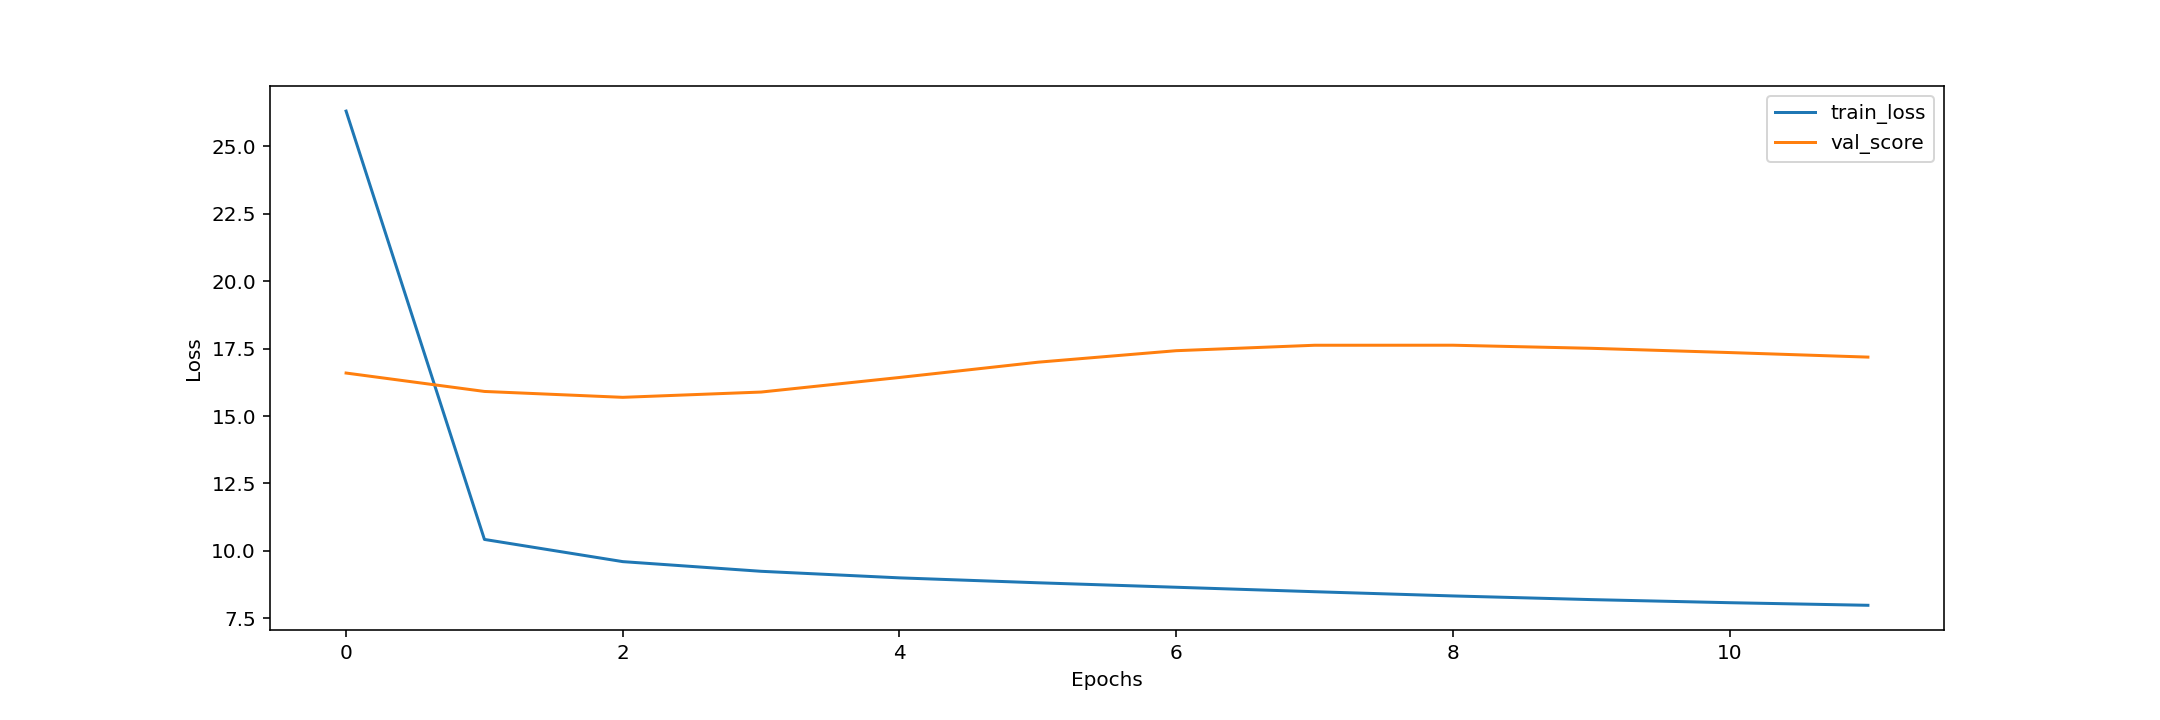

In [7]:
def plot_loss(train_loss, val_loss, num_epochs):   
    fig = plt.figure(figsize=[15,5])
    plt.plot(range(num_epochs), train_loss, label='train_loss')
    plt.plot(range(num_epochs), val_loss, label='val_score')

    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plot_loss(H['train_loss'], H['val_loss'], 12)

In [29]:
torch.cuda.device_count()

3

In [31]:
torch.__version__

'1.13.0a0+08820cb'

In [10]:
a = "readu:=" + '"st.bf"'
a

'readu:="st.bf"'

In [3]:
encoder1 = VisionTransformer(input_channels=1)
encoder2 = VisionTransformer()
decoder = TransformerDecoder()

model = AttnNav(encoder2, encoder1, decoder)
dm = NavSetDataModule("./data", "./data/train_bags", "./data/val_bags")

13
4


In [4]:
from pytorch_lightning import Trainer
trainer = Trainer(
        accelerator='gpu',
        gpus=1,
        limit_train_batches=10, limit_val_batches=5,
        #logger=pl_loggers.TensorBoardLogger("lightning_logs/clip_social_nav/"),
        #callbacks=[model_checkpoint_cb, swa_cb],
        #gradient_clip_val=1.0,
        max_epochs=2,
        log_every_n_steps=2)

# fit model
trainer.fit(model, dm)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache

Epoch 0:  67%|████████████████        | 10/15 [00:03<00:01,  3.05it/s, loss=443, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████| 15/15 [00:04<00:00,  3.05it/s, loss=443, v_num=11, val_loss=75.00]
Epoch 1:  67%|▋| 10/15 [00:03<00:01,  2.96it/s, loss=255, v_num=11, val_loss=75.00, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                      | 0/5 [00:00<?, ?it/s]
Epoch 1:  73%|▋| 11/15 [00:04<00:01,  2.28it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1:  80%|▊| 12/15 [00:04<00:01,  2.47it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1:  87%|▊| 13/15 [00:04<00:00,  2.64it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1:  93%|▉| 14/15 [00:04<00:00,  2.80it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1: 100%|█| 15/15 [00:05<00:00,  2.93it/s, loss=255, v_num=11, val_loss=64.80, train_
Epoch 1: 100%|█| 15/15 [00:05<00:00,  2.93it/s, loss=255, v_num=11, val_loss=64.80, train_

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|█| 15/15 [00:05<00:00,  2.70it/s, loss=255, v_num=11, val_loss=64.80, train_


In [9]:
a = [b for b in os.listdir("./data/train_bags") if os.path.isfile(os.path.join("./data/train_bags",b))]
a

['A_Spot_Fountain_Library_Mon_Nov_8_26.bag',
 'A_Spot_AHG_Library_Wed_Nov_10_46.bag',
 'A_Spot_Butler_Foodtruck_Fri_Nov_26_132.bag',
 'A_Spot_Bass_Rec_Fri_Nov_26_126.bag',
 'A_Spot_Stadium_Rec_Fri_Nov_26_135.bag',
 'A_Spot_AHG_Library_Fri_Nov_5_21.bag',
 'A_Spot_Stadium_PerformingArtsCenter_Sat_Nov_13_106.bag',
 'A_Spot_GDC_Jester_Thu_Nov_18_121.bag',
 'A_Spot_Library_AHG_Tue_Nov_9_43.bag',
 'A_Spot_Parlin_Parlin_Wed_Nov_10_51.bag',
 'A_Spot_LBJ_Stadium_Sat_Nov_13_105.bag',
 'A_Spot_EER_AHG_Mon_Nov_8_32.bag',
 'A_Spot_Library_Dobie_Wed_Nov_10_57.bag']

In [8]:
os.path.isfile(a[0])

False

In [7]:
from pytorch_lightning import Trainer
trainer = Trainer(
        accelerator='gpu',
        gpus=1,
        #logger=pl_loggers.TensorBoardLogger("lightning_logs/clip_social_nav/"),
        #callbacks=[model_checkpoint_cb, swa_cb],
        #gradient_clip_val=1.0,
        max_epochs=2,
        log_every_n_steps=20)

# fit model
trainer.fit(model, dm)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type               | Params
-----------------------------------------------------
0 | rgb_encoder   | VisionTransformer 

Epoch 0:   3%| | 79/2452 [00:19<09:38,  4.10it/s, loss=1.55, v_num=2, train_loss_step=0.75

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
from train import train

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7641/3058615774.py", line 1, in <cell line: 1>
    from train import train
  File "/workspace/project/train/train.py", line 35, in <module>
    datamodel = NavSetDataModule(save_data_path=CFG.save_data_path,
  File "/workspace/project/models/dataloader.py", line 103, in __init__
    self.train_bags = [b for b in os.listdir(train_rosbag_path) if os.path.isfile(os.path.join(train_rosbag_path,b))]
FileNotFoundError: [Errno 2] No such file or directory: '../data/train_bags/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/conda/lib/python3.8/site-pac

In [8]:
import train.config